In [ ]:
from keras.models import *
from keras.layers import *
from keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [ ]:
def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [ ]:
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def binary_focal_loss(gamma, alpha):
    """
    Binary form of focal loss.
         Focal loss for binary classification problems
    
    focal_loss(p_t) = -alpha_t * (1 - p_t)**gamma * log(p_t)
        where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    alpha = tf.constant(alpha, dtype=tf.float32)
    gamma = tf.constant(gamma, dtype=tf.float32)

    def binary_focal_loss_fixed(y_true, y_pred):
        """
        y_true shape need be (None,1)
        y_pred need be compute after sigmoid
        """
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true*alpha + (K.ones_like(y_true)-y_true)*(1-alpha)
    
        p_t = y_true*y_pred + (K.ones_like(y_true)-y_true)*(K.ones_like(y_true)-y_pred) + K.epsilon()
        focal_loss = - alpha_t * K.pow((K.ones_like(y_true)-p_t),gamma) * K.log(p_t)
        return K.mean(focal_loss)
    return binary_focal_loss_fixed

In [ ]:
image_test = np.load('/content/drive/MyDrive/Gigi/Output/300/300_dengan_tanpa_kanal_test_image.npy')
region_test = np.load('/content/drive/MyDrive/Gigi/Output/300/300_dengan_tanpa_kanal_test_region.npy')
boundary_test = np.load('/content/drive/MyDrive/Gigi/Output/300/300_dengan_tanpa_kanal_test_boundary.npy')

In [ ]:
x_test = np.expand_dims(image_test, axis=3).astype('float32')
r_test = np.expand_dims(region_test, axis=3).astype('float32')
b_test = np.expand_dims(boundary_test, axis=3).astype('float32')

In [ ]:
model = load_model("/content/drive/MyDrive/Gigi/Output/Weight/Percobaan untuk jurnal/300 RFNC + DAL (Region 0.2, Boundary 0.8).h5", 
                   custom_objects={'dice_coef': dice_coef, 'binary_focal_loss_fixed' : binary_focal_loss(gamma = 2., alpha = 0.25)})
# model.summary()

In [ ]:
result = model.predict(x_test1)

In [ ]:
gabung = []
for i in range(len(r_test)):
  g = result[0][i] + result[1][i]
  # g = asarray(g)
  g[g < 1] = 0
  g[g >= 1] = 1
  gabung.append(g)

In [ ]:
gabung2 = []
for i in range(len(r_test)):
  g = result[0][i] + result[1][i]
  gabung2.append(g)

In [ ]:
dice_r = dice_coef(result[0], r_test)
precision_r = precision_m(result[0], r_test)
recall_r = recall_m(result[0], r_test)

dice_b = dice_coef(result[1], b_test)
precision_b = precision_m(result[1], b_test)
recall_b = recall_m(result[1], b_test)

dice_g = dice_coef(gabung, r_test)
precision_g = precision_m(gabung, r_test)
recall_g = recall_m(gabung, r_test)

dice_g2 = dice_coef(gabung2, r_test)
precision_g2 = precision_m(gabung2, r_test)
recall_g2 = recall_m(gabung2, r_test)

In [ ]:
with tf.compat.v1.Session() as sess:
  print('----Region----\nDice Coef Score\t: ' +str(dice_r.numpy())+ '\nPrecision\t: ' +str(precision_r.numpy())+ '\nRecall\t\t: '+str(recall_r.numpy()))
  print('\n----Boundary----\nDice Coef Score\t: ' +str(dice_b.numpy())+ '\nPrecision\t: ' +str(precision_b.numpy())+ '\nRecall\t\t: '+str(recall_b.numpy()))
  print('\n----Gabungan----\nDice Coef Score\t: ' +str(dice_g.numpy())+ '\nPrecision\t: ' +str(precision_g.numpy())+ '\nRecall\t\t: '+str(recall_g.numpy()))
  print('\n----Gabungan 2----\nDice Coef Score\t: ' +str(dice_g2.numpy())+ '\nPrecision\t: ' +str(precision_g2.numpy())+ '\nRecall\t\t: '+str(recall_g2.numpy()))

----Region----
Dice Coef Score	: 0.804245
Precision	: 0.7602102
Recall		: 0.92323124

----Boundary----
Dice Coef Score	: 0.6283851
Precision	: 0.57717866
Recall		: 0.76632214

----Gabungan----
Dice Coef Score	: 0.6368675
Precision	: 0.53483486
Recall		: 0.7870084

----Gabungan 2----
Dice Coef Score	: 0.8689127
Precision	: 0.85495496
Recall		: 0.7380428


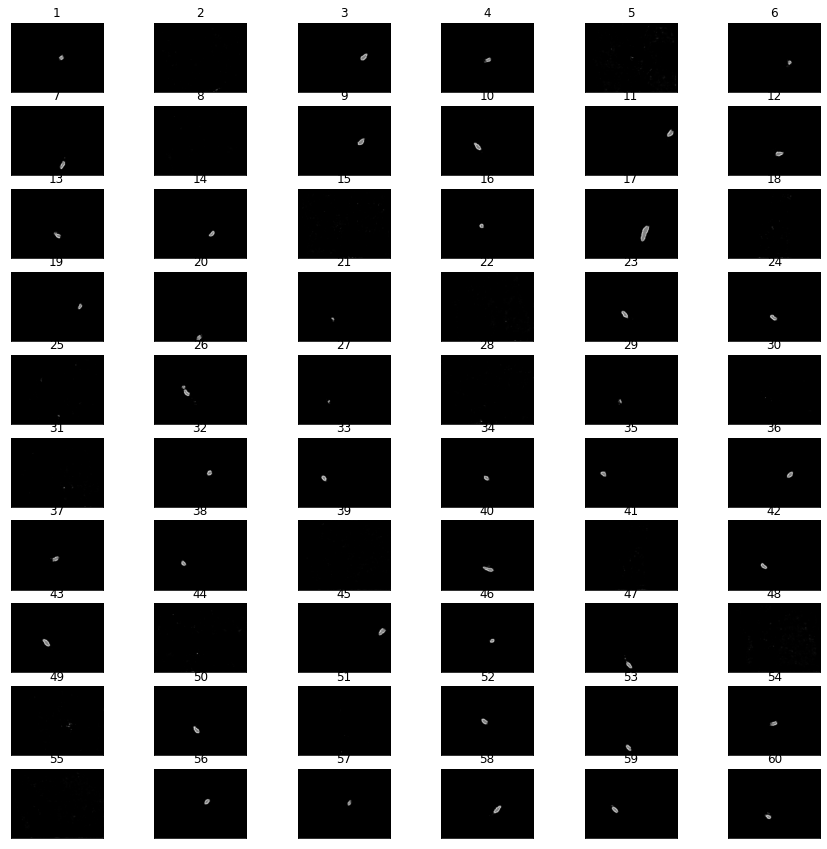

In [ ]:
fig = plt.figure(figsize=(15, 15))
for i in range(len(gabung2)):
  plt.subplot(10,6,i+1),plt.imshow(gabung2[i].reshape(192,256),cmap = 'gray')
  plt.title(i+1), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
def show(img):
    img2 = img[:,:,::-1]
    plt.imshow(img2)

In [ ]:
def draw_result(image, region_gt, result):
  img = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
  mask = cv2.normalize(region_gt, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
  result = cv2.normalize(result.reshape(192,256), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

  ret,th = cv2.threshold(result,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  ret2,th2 = cv2.threshold(mask,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  contours = []
  gabungan_contours,_ = cv2.findContours(th, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  mask_contours,_ = cv2.findContours(th2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours.append(mask_contours)
  contours.append(gabungan_contours)

  main = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
  for i,c in enumerate(contours):
    if i == 0:
      color = (0,255,255)
    else:
      color = (0,0,255) #mask

    cv2.drawContours(main,c,-1,color,-1)
  return main

In [ ]:
fig = plt.figure(figsize=(10, 10))
show(draw_result(image_test[7], region_test[7], gabung2[7]))
plt.show()